# Theory of SEIR Model

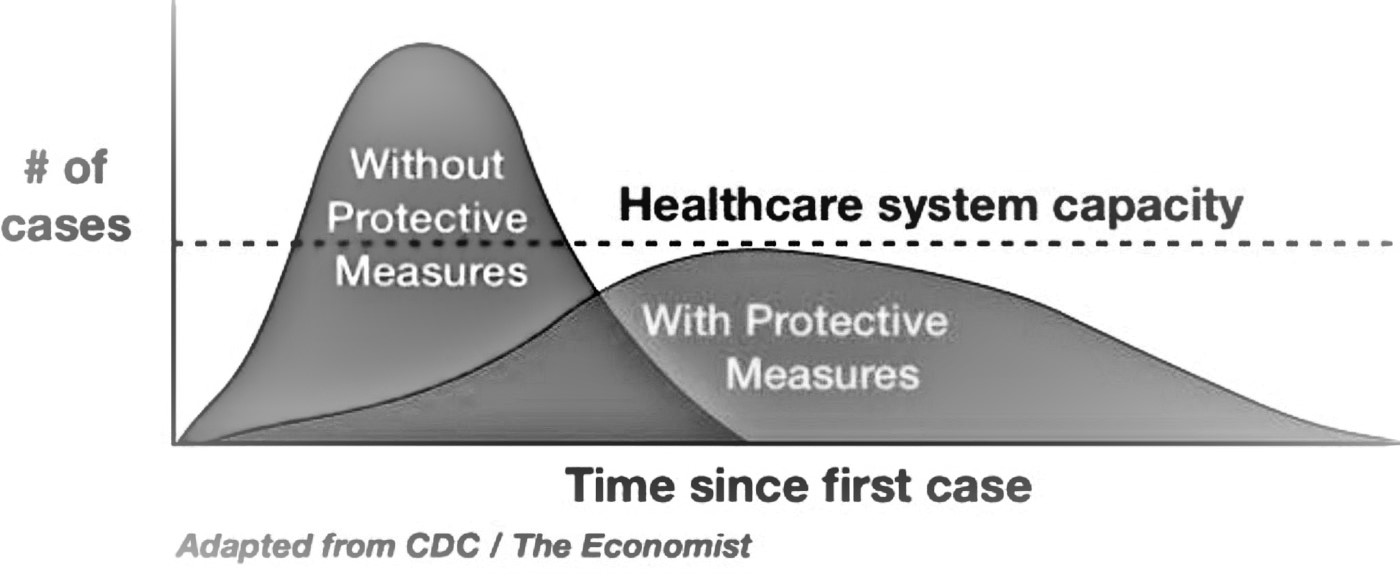

In [261]:
from IPython.display import Image
Image(path_dir+"input\\SEIR_Theory2.png")

The idea is to reduce person-to-person contact in order to make spreading the disease less likely. The effects of this are often illustrated in images above, where the left plot is flattened to spread out the disease as much as possible. This helps to ensure that there are sufficient resources available for a sick population, which will help improve survival rates.

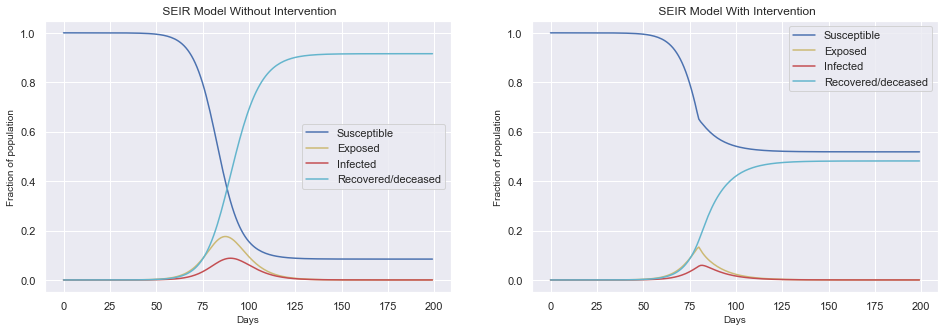

In [266]:
N = 1000000  # Population size
n_infected = 1
max_days = 200
initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0]

R_0 = 2.7 #Reproductive Number
t_inc = 5.6 #Incubation Period
t_inf = 2.9 #REcovery Period

args = (R_0, t_inc, t_inf)
sol11 = solve_ivp(seir_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

def time_varying_reproduction1(t):
    if t > intervention_day:
        return R_t
    else:
        return R_0
    
intervention_day = 80
R_t = 0.7

args = (time_varying_reproduction1, t_inc, t_inf)
sol12 = solve_ivp(seir_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

# Plot General SEIR model Result

sns.set(style="darkgrid")
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))
ax1.set_title(' SEIR Model Without Intervention')
ax2.set_title(' SEIR Model With Intervention')

sus, exp, inf, rec = sol11.y
ax1.plot(sus, 'b', label='Susceptible');
ax1.plot(exp, 'y', label='Exposed');
ax1.plot(inf, 'r', label='Infected');
ax1.plot(rec, 'c', label='Recovered/deceased');
ax1.set_xlabel("Days", fontsize=10);
ax1.set_ylabel("Fraction of population", fontsize=10);
ax1.legend(loc='best')

sus, exp, inf, rec = sol12.y
ax2.plot(sus, 'b', label='Susceptible');
ax2.plot(exp, 'y', label='Exposed');
ax2.plot(inf, 'r', label='Infected');
ax2.plot(rec, 'c', label='Recovered/deceased');
ax2.set_xlabel("Days", fontsize=10);
ax2.set_ylabel("Fraction of population", fontsize=10);
ax2.legend(loc='best')

# Reading & Data Prepration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
import scipy.stats as st
from sklearn.metrics import mean_squared_error,mean_squared_log_error
from scipy.optimize import curve_fit, fsolve, minimize
import time
from datetime import datetime, timedelta
from scipy import integrate, optimize
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
path_dir = 'C:\\Users\\kumapank\\Documents\\COVID-19\\'

In [3]:
conf_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series_covid19_confirmed_global_narrow.csv')
conf_df = conf_df.drop(index=0)
dth_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series_covid19_deaths_global_narrow.csv')
dth_df = dth_df.drop(index=0)
rcv_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series_covid19_recovered_global_narrow.csv')
rcv_df = rcv_df.drop(index=0)
conf_df.Date = pd.to_datetime(conf_df.Date, format='%Y-%m-%d')
dth_df.Date = pd.to_datetime(dth_df.Date, format='%Y-%m-%d')
rcv_df.Date = pd.to_datetime(rcv_df.Date, format='%Y-%m-%d')

In [4]:
df = pd.merge(conf_df,dth_df,left_on=['Province/State','Country/Region','Lat','Long','Date'],right_on=['Province/State','Country/Region','Lat','Long','Date'],how='left')
df.columns = ['Province/State','Country/Region','Lat','Long','Date','Confirmed','Death']
df = pd.merge(df,rcv_df,left_on=['Province/State','Country/Region','Lat','Long','Date'],right_on=['Province/State','Country/Region','Lat','Long','Date'],how='left')
df.columns = ['Province/State','Country/Region','Lat','Long','Date','Confirmed','Death','Recovered']
df = df.sort_values(by=['Province/State','Country/Region','Date'], ascending=(True,True,True))
df.Confirmed = df.Confirmed.fillna(0)
df.Death = df.Death.fillna(0)
df.Recovered = df.Recovered.fillna(0)
df.Confirmed = df.Confirmed.astype(int)
df.Death = df.Death.astype(int)
df.Recovered = df.Recovered.astype(int)
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Death,Recovered
2839,Alberta,Canada,53.9333,-116.5765,2020-01-22,0,0,0
2838,Alberta,Canada,53.9333,-116.5765,2020-01-23,0,0,0
2837,Alberta,Canada,53.9333,-116.5765,2020-01-24,0,0,0
2836,Alberta,Canada,53.9333,-116.5765,2020-01-25,0,0,0
2835,Alberta,Canada,53.9333,-116.5765,2020-01-26,0,0,0


## Data Cleaning

In [5]:
Date_threshold = '2020-03-26' # Cutoff date to validate the results

In [6]:
col_list = ['Province/State','Country/Region','Date','Confirmed','Death','Recovered']
df = df[col_list]

# Creating population disctionary lookup table
# Load the population data into lookup dicts
pop_info = pd.read_csv(path_dir+ 'input\\population_data.csv')
country_pop = pop_info.query('Type == "Country/Region"')
province_pop = pop_info.query('Type == "Province/State"')
country_lookup = dict(zip(country_pop['Name'], country_pop['Population']))
province_lookup = dict(zip(province_pop['Name'], province_pop['Population']))

df['Area'] = df['Province/State'].fillna(df['Country/Region'])

# cummax function to remove some data cumulation anomalies 
df['Confirmed'] = df.groupby('Area')['Confirmed'].cummax()
df['Death'] = df.groupby('Area')['Death'].cummax()
df['Recovered'] = df.groupby('Area')['Recovered'].cummax()

df['Removed'] = df.Death + df.Recovered
df['ActiveInfected'] = df.Confirmed - df.Removed
req_col = ['ActiveInfected','Removed']

# Multi-index 
df.set_index(['Area', 'Date'], inplace=True)
df = df[req_col]
df.shape

(18176, 2)

# Train SEIR Model for COVID19

## Important Functions

In [7]:
# SEIR Model Equation
def seir_model(t,initial_val, R_0, T_inc,T_inf):
    
    if callable(R_0):
        R_t = R_0(t)
    else:
        R_t = R_0
    
    alpha = 1/T_inc # rate of expose
    gamma = 1/T_inf # rate of recovery
    beta = R_t/T_inf # rate of infection
    
    S, E, I, R= initial_val 
    
    dSdt = -(beta * S * I) 
    dEdt = (beta * S * I) - (alpha * E)
    dIdt = (alpha * E) - (gamma * I)
    dRdt = gamma * I
    
    return dSdt, dEdt, dIdt, dRdt;

In [9]:
# Over loop find the best estimate for alpha beta and gamma
def seir_param_estimate(R0_bound,inc_bound,rcv_bound,data,population,max_days=200):
    active_infected = data['ActiveInfected'].values
    N = population
    R0_list = np.arange(R0_bound[0],R0_bound[1],0.1)
    inc_list = np.arange(inc_bound[0],inc_bound[1],0.1)
    rcv_list = np.arange(rcv_bound[0],rcv_bound[1],0.1)
    n_infected = active_infected[0]
    initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0]

    R0_est = []
    for R0 in R0_list:
        for inc in inc_list:
            for rcv in rcv_list:
                argms = [R0,inc,rcv]
                sol = solve_ivp(seir_model, [0,max_days], initial_state, args=argms, t_eval=np.arange(max_days))
                errors = mean_squared_error(sol.y[2][0:len(active_infected)],active_infected/N)
                R0_step = [R0,inc,rcv,errors*N]
                R0_est.append(R0_step)

    R0_est = pd.DataFrame(R0_est,columns=['R0','Incubation','Recovery','MSE'])
    R0_est = R0_est.sort_values(by=['MSE','R0','Incubation','Recovery'], ascending=[True,True,True,True]).reset_index(drop=True)
    param_estimate = R0_est
#     best_estimate_param =R0_est.iloc[0,:].values    
    return param_estimate;

In [137]:
#Plot SEIR Model Results
def plot_results(country,pred_df,intervention_param,best_estimate_param,
                 Obs_start = '2020-03-01',Obs_end = '2020-05-01',all_pic=False):
    if all_pic:
        if intervention_param[0] == None:
            intervention = pd.to_datetime(min(pred_df.index))
        else:
            intervention = pd.to_datetime(intervention_param[0])
        sns.set(style="darkgrid")
        fig, ax1 = plt.subplots(1, figsize=(12,6))
        ax1.set_title(country + ' SEIR Model Projection')
        pred_df.loc[pred_df.index,'ActiveInfected'].plot(label='Training Actual Infection', color='r', ax=ax1)
        ax1.axvline(x=min(pred_df[pred_df.index> Date_threshold].index),color='black',linestyle = '--', 
                    label='Training Boundary')
        pred_df.loc[pred_df.index,'without_itr_INF'].plot(label='No Interven Pred Infection', color='b', ax=ax1)
        ax1.plot(intervention,0,'^',label='Intervention Day') 
        pred_df.loc[pred_df.index,'without_intr_SUS'].plot(label='No Interven Susceptible', color='g', ax=ax1)
        pred_df.loc[pred_df.index,'with_intr_INF'].plot(label='With Interven Pred Infection', color='b',linestyle=':', ax=ax1)
        pred_df.loc[pred_df.index,'with_intr_SUS'].plot(label='With Interven Susceptible', color='c', ax=ax1)
        pred_df.loc[pred_df.index,'with_intr_EXP'].plot(label='With Interven Exposed', color='y', ax=ax1)
        ax1.set_ylabel("% of Susceptable Population")
        ax1.legend(loc='best')

    else:
        if intervention_param[0] == None:
            intervention = pd.to_datetime(min(pred_df.index))
        else:
            intervention = pd.to_datetime(intervention_param[0])
        temp = pred_df[(pred_df.index >= Obs_start) & (pred_df.index <= Obs_end)]
        sns.set(style="darkgrid")
        fig, ax2 = plt.subplots(1, figsize=(12,6))
        ax2.set_title(country + ' SEIR Model Projection for Infected Population')
        temp.loc[temp.index,'ActiveInfected'].plot(label='Training Actual Infection', color='r', ax=ax2)
        ax2.axvline(x=min(temp[temp.index> Date_threshold].index),color='black',linestyle = '--', label='Training Boundary')
        temp.loc[temp.index,'without_itr_INF'].plot(label='No Interven Pred Infection', color='b', ax=ax2)
        ax2.plot(intervention,0,'^',label='Intervention Day') 
        temp.loc[temp.index,'with_intr_INF'].plot(label='With Interven Pred Infection', color='b',linestyle=':', ax=ax2)
#         temp.loc[temp.index,'with_intr_EXP'].plot(label='With Interven Exposed', color='y', ax=ax2)
        ax2.set_ylabel("% of Susceptable Population")
        ax2.legend(loc='best')
        del(temp)
    return print("Estimated Parameter: R0 %5.2f, | Training Mean Square Error: %5.3f " 
                 %(best_estimate_param[0],best_estimate_param[3]))


In [23]:
#Predict Covid 19 Incidence
def predict_covid_instance(best_estimate_param,data,population,intervention_param, max_days = 200):    

    train = data[data.index<= Date_threshold]
    st_dt = pd.to_datetime(min(data.index),format='%Y-%m-%d')
    dates_all = np.array([ st_dt + timedelta(days=x) for x in range(0,max_days)])

    active_infected = train['ActiveInfected'].values
    N = population
    n_infected = active_infected[0]
    initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0]
    
    if intervention_param[0] == None:
        without_intr_sol = solve_ivp(seir_model, [0, max_days], initial_state, args=best_estimate_param[:-1], 
                             t_eval=np.arange(max_days))
        without_intr_sol = without_intr_sol.y
        with_intr_sol = without_intr_sol
        
    else:        
        without_intr_sol = solve_ivp(seir_model, [0, max_days], initial_state, args=best_estimate_param[:-1], 
                                     t_eval=np.arange(max_days))
        without_intr_sol = without_intr_sol.y
        
        intervention_day = (pd.to_datetime(intervention_param[0],format='%Y-%m-%d')- st_dt).days
#         [0 if x<0 else x for x in [intervention_day]][0]
        
        def time_varying_reproduction(t):
            if t > intervention_day:
                return intervention_param[1]
            else:
                return best_estimate_param[:-1][0]

        argms = [time_varying_reproduction,best_estimate_param[:-1][1],best_estimate_param[:-1][2]] 
        with_intr_sol = solve_ivp(seir_model, [0, max_days], initial_state, args=argms, t_eval=np.arange(max_days))
        with_intr_sol = with_intr_sol.y

    pred_df = pd.DataFrame({'without_intr_SUS': np.clip(without_intr_sol[0],0,np.inf),
                          'without_itr_INF': np.clip(without_intr_sol[2],0,np.inf),
                          'with_intr_SUS': np.clip(with_intr_sol[0],0,np.inf),
                          'with_intr_EXP': np.clip(with_intr_sol[1],0,np.inf),
                          'with_intr_INF': np.clip(with_intr_sol[2],0,np.inf)},index=dates_all)
    data['ActiveInfected'] = data['ActiveInfected']/N
    pred_df=pred_df.join(data)
    return pred_df

## Train SEIR Parameters

In [24]:
# Retrain or extract the country SEIR parameters
def extract_train_param(area_name, R0_bound,inc_bound,rcv_bound, retrain=False):

    try:
        population = country_lookup[area_name]
    except KeyError:
        population = province_lookup[area_name]
    sigma = 0.025
    N = population*sigma
       
    file_name = path_dir+'\\output\\Country_Param_Estimates\\'+area_name+".csv" 
    if retrain:
        best_estimate_param = seir_param_estimate(R0_bound,inc_bound,rcv_bound,country_df,N,max_days=200)
        best_estimate_param.to_csv(file_name, index=False) 
    else:
        try:
            best_estimate_param = pd.read_csv(file_name)
        except FileNotFoundError:
            best_estimate_param = seir_param_estimate(R0_bound,inc_bound,rcv_bound,country_df,N,max_days=200)
            best_estimate_param.to_csv(file_name, index=False)  
    
    return best_estimate_param

In [25]:
def display_output(area_name,intervention_param,obs_start,obs_end,full_SEIR_graph=False,retrain=False,i=0):
    #     area_name = 'US'
    data = df.loc[area_name].query('ActiveInfected > 1')
    
    try:
        population = country_lookup[area_name]
    except KeyError:
        population = province_lookup[area_name]

    sigma = 0.025
    N = population*sigma

    best_param = extract_train_param(area_name, R0_bound=[1.2,5.2],inc_bound=[4.5,11.1],rcv_bound=[1.2,5],retrain=retrain)
    best_estimate_param = best_param.iloc[i,:].values

    pred_df = predict_covid_instance(best_estimate_param,data,N,intervention_param)
    plot_results(area_name ,pred_df,intervention_param,best_estimate_param,obs_start,obs_end,all_pic=full_SEIR_graph)
    
    if intervention_param[0] == None:        
        Max_infected_people = int(max(pred_df.without_itr_INF)*N)
        st = pred_df[pred_df.without_itr_INF==max(pred_df.without_itr_INF)].index        
        print('Apex Day Without Intervention:', st[0].strftime("%b %d %Y"),'| Maximum Active Infected Population:',Max_infected_people)
    else:
        Max_infected_people = int(max(pred_df.without_itr_INF)*N)
        st = pred_df[pred_df.without_itr_INF==max(pred_df.without_itr_INF)].index 
        
        Max_infected_people1 = int(max(pred_df.with_intr_INF)*N)
        st1 = pred_df[pred_df.with_intr_INF==max(pred_df.with_intr_INF)].index 
        print('Apex Day Without Intervention:', st[0].strftime("%b %d %Y"),'| Maximum Active Infected Population:',Max_infected_people)
        print('Apex Day With Intervention:', st1[0].strftime("%b %d %Y"),'| Maximum Active Infected Population:',Max_infected_people1)

    return

In [14]:
# data = df.loc['Spain'].query('ActiveInfected > 1')
# best_param = extract_train_param('Spain', R0_bound=[1.2,5.2],inc_bound=[4.5,11.1],rcv_bound=[1.2,5],retrain=False)
# best_param = best_param.iloc[10100,:].values
# population = 500000
# intervention_param = [None, 0.7]
# pred = predict_covid_instance(best_param,data,population,intervention_param, max_days = 200)
# # int(max(pred.without_itr_INF)*population)
# st = pred[pred.without_itr_INF==max(pred.without_itr_INF)].index
# st[0].strftime("%b %d %Y")

In [15]:
# best_param = extract_train_param('US', R0_bound=[1.2,5.2],inc_bound=[4.5,11.1],rcv_bound=[1.2,5],retrain=True)
# # best_param.iloc[0,:].values
# best_param.head()

## Model Prediction

### US Projection

Estimated Parameter: R0  4.60, | Training Mean Square Error: 1.403 
Apex Day Without Intervention: Apr 16 2020 | Maximum Active Infected Population: 729147
Apex Day With Intervention: Apr 25 2020 | Maximum Active Infected Population: 504281


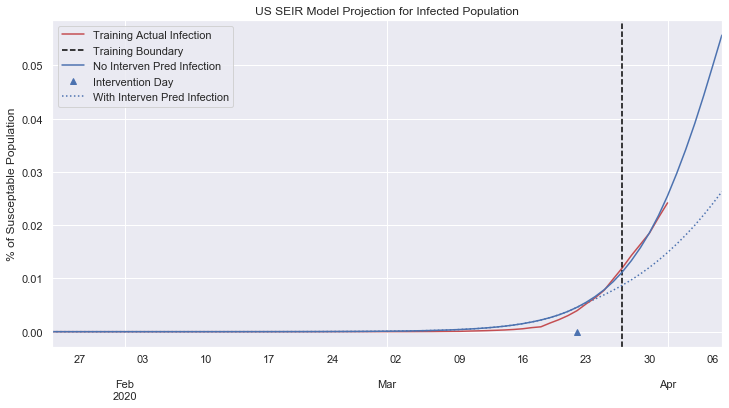

In [254]:
social_distancing_param = 0.658
intervention_param = ['2020-03-22', social_distancing_param*4.6] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-04-07'

display_output('US',intervention_param,obs_start,obs_end,full_SEIR_graph=False,retrain=False,i=0) 

Estimated Parameter: R0  4.60, | Training Mean Square Error:  1.40 
Apex Day Without Intervention: Apr 16 2020 | Maximum Active Infected Population: 729147
Apex Day With Intervention: Apr 26 2020 | Maximum Active Infected Population: 499254


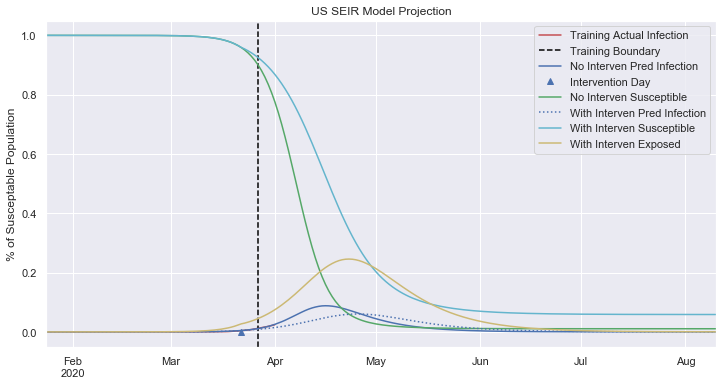

In [95]:
social_distancing_param = 0.658
intervention_param = ['2020-03-22', social_distancing_param*4.6] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-04-07'

display_output('US',intervention_param,obs_start,obs_end,full_SEIR_graph=True,retrain=False,i=0) 

### Spain Projection

Estimated Parameter: R0  3.20, | Training Mean Square Error: 224.93 
Apex Day Without Intervention: Apr 02 2020 | Maximum Active Infected Population: 95684
Apex Day With Intervention: Apr 03 2020 | Maximum Active Infected Population: 73547


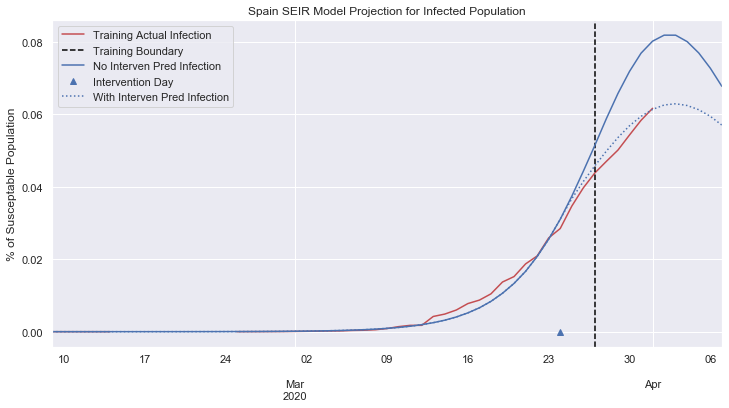

In [32]:
intervention_param = ['2020-03-24', 2.4] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-04-07'

display_output('Spain',intervention_param,obs_start,obs_end,full_SEIR_graph=False,retrain=False,i=10000) 


Estimated Parameter: R0  3.20, | Training Mean Square Error: 224.93 
Apex Day Without Intervention: Apr 02 2020 | Maximum Active Infected Population: 95684
Apex Day With Intervention: Apr 03 2020 | Maximum Active Infected Population: 73547


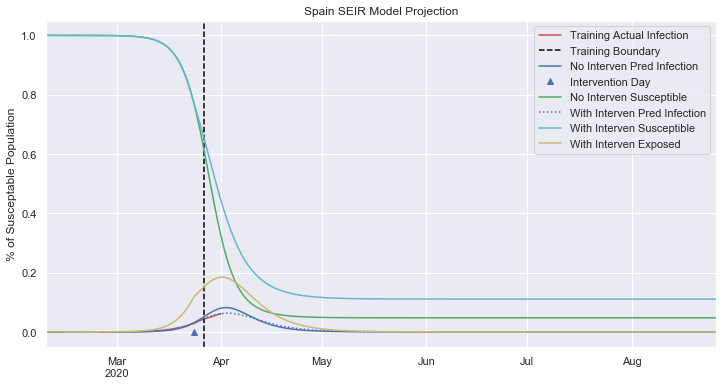

In [33]:
intervention_param = ['2020-03-24', 2.4] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-04-05'

display_output('Spain',intervention_param,obs_start,obs_end,full_SEIR_graph=True,retrain=False,i=10000) 

### Italy Projection

Estimated Parameter: R0  3.80, | Training Mean Square Error: 22.09 
Apex Day Without Intervention: Apr 03 2020 | Maximum Active Infected Population: 120384
Apex Day With Intervention: Apr 04 2020 | Maximum Active Infected Population: 85924


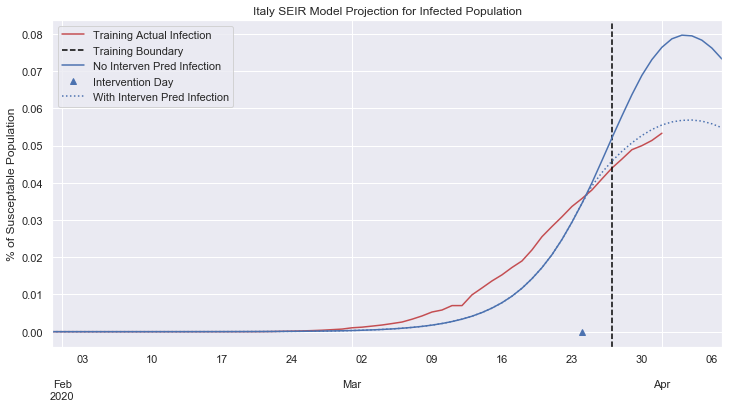

In [87]:
intervention_param = ['2020-03-24', 2.4] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-04-07'

display_output('Italy',intervention_param,obs_start,obs_end,full_SEIR_graph=False,retrain=False,i=970) #900

Estimated Parameter: R0  3.80, | Training Mean Square Error: 22.09 
Apex Day Without Intervention: Apr 03 2020 | Maximum Active Infected Population: 120384
Apex Day With Intervention: Apr 04 2020 | Maximum Active Infected Population: 85924


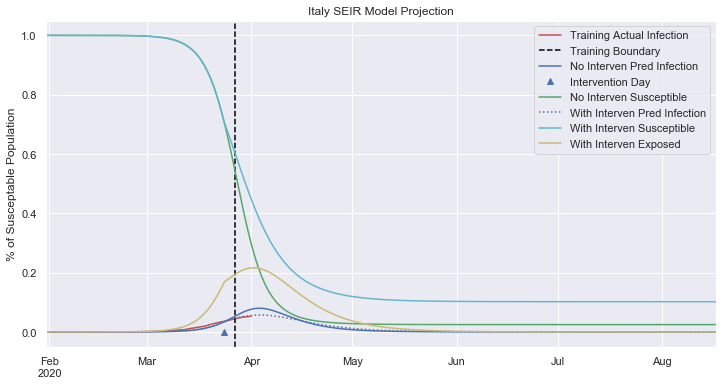

In [88]:
intervention_param = ['2020-03-24', 2.4] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-04-07'

display_output('Italy',intervention_param,obs_start,obs_end,full_SEIR_graph=True,retrain=False,i=970) #900

### India Projection

Estimated Parameter: R0  3.10, | Training Mean Square Error: 0.002 
Apex Day Without Intervention: Jun 03 2020 | Maximum Active Infected Population: 1613823
Apex Day With Intervention: Jun 15 2020 | Maximum Active Infected Population: 1354508


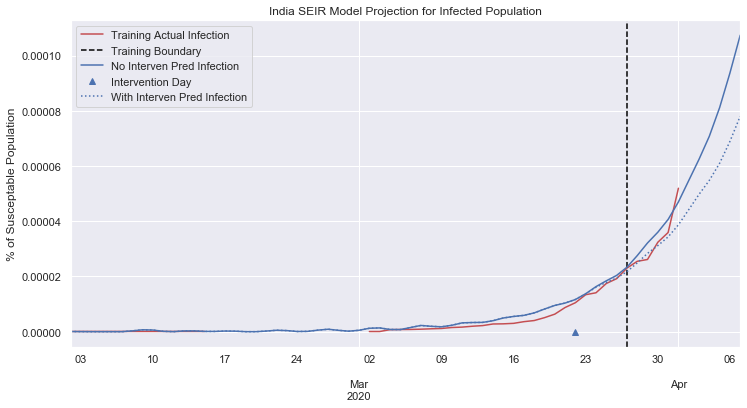

In [256]:
social_distancing_param = 0.8709
intervention_param = ['2020-03-22', social_distancing_param*3.1] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-04-07'

display_output('India',intervention_param,obs_start,obs_end,full_SEIR_graph=False,retrain=False,i=30000) #29000

Estimated Parameter: R0  3.10, | Training Mean Square Error: 0.002 
Apex Day Without Intervention: Jun 03 2020 | Maximum Active Infected Population: 1613823
Apex Day With Intervention: Jun 15 2020 | Maximum Active Infected Population: 1354673


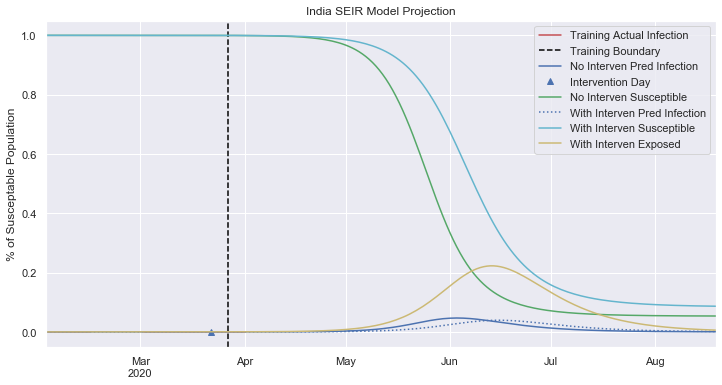

In [145]:
social_distancing_param = 0.8709
intervention_param = ['2020-03-22', social_distancing_param*3.1] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-04-07'

display_output('India',intervention_param,obs_start,obs_end,full_SEIR_graph=True,retrain=False,i=30000) #29000

### United Arab Emirates Projection

Estimated Parameter: R0  2.10, | Training Mean Square Error: 0.003 
Apex Day Without Intervention: May 23 2020 | Maximum Active Infected Population: 13520
Apex Day With Intervention: May 08 2020 | Maximum Active Infected Population: 20548


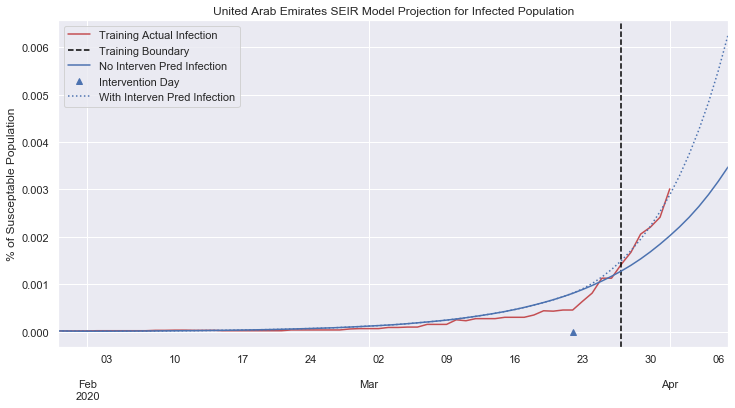

In [167]:
intervention_param = ['2020-03-22', 2.7] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-04-07'

display_output('United Arab Emirates',intervention_param,obs_start,obs_end,full_SEIR_graph=False,retrain=False,i=1400) #1400

Estimated Parameter: R0  2.10, | Training Mean Square Error: 0.003 
Apex Day Without Intervention: May 23 2020 | Maximum Active Infected Population: 13520
Apex Day With Intervention: May 08 2020 | Maximum Active Infected Population: 20548


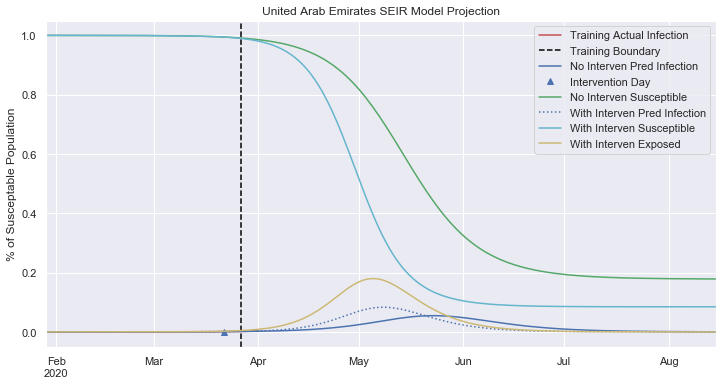

In [168]:
intervention_param = ['2020-03-22', 2.7] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-04-07'

display_output('United Arab Emirates',intervention_param,obs_start,obs_end,full_SEIR_graph=True,retrain=False,i=1400) #1400

### South Korea Projection (WIP)

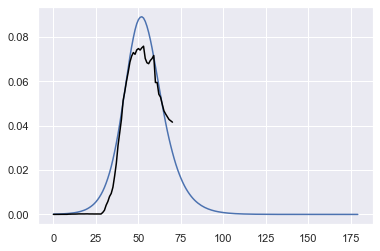

In [253]:
N = 100000 #1000000  # Population size
n_infected = 1
max_days = 200

initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0]
args1 = [2.7,5.3,2.8]
sol1 = solve_ivp(seir_model, [0, max_days], initial_state, args=args1, t_eval=np.arange(max_days))
scen1 = sol1.y[2]
# args2 = [2.5,5.6,2.9]
# sol2 = solve_ivp(seir_model, [0, max_days], initial_state, args=args2, t_eval=np.arange(max_days))
# scen2 = sol2.y[2]
# args3 = [3,5.6,2.9]
# sol3 = solve_ivp(seir_model, [0, max_days], initial_state, args=args3, t_eval=np.arange(max_days))
# scen3 = sol3.y[2]
# args4 = [4,5.6,2.9]
# sol4 = solve_ivp(seir_model, [0, max_days], initial_state, args=args4, t_eval=np.arange(max_days))
# scen4 = sol4.y[2]
# args5 = [5,5.6,2.9]
# sol5 = solve_ivp(seir_model, [0, max_days], initial_state, args=args5, t_eval=np.arange(max_days))
# scen5 = sol5.y[2]

data = df.loc['Korea, South']
plt.plot(scen1[20:])
# plt.plot(scen2)
# plt.plot(scen3)
# plt.plot(scen4)
# plt.plot(scen5)
plt.plot(data.ActiveInfected.values/100000, color='black')

Estimated Parameter: R0  3.60, | Training Mean Square Error: 15.545 
Apex Day Without Intervention: Apr 16 2020 | Maximum Active Infected Population: 101635


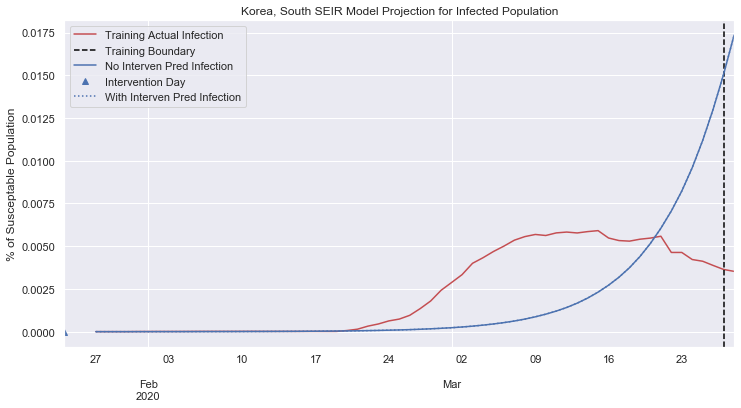

In [216]:
intervention_param = [None, 5] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-27'
obs_end = '2020-03-28'

display_output('Korea, South',intervention_param,obs_start,obs_end,full_SEIR_graph=False,retrain=False,i=56310) #6470

Estimated Parameter: R0  2.70, | Training Mean Square Error: 12.58 
Apex Day Without Intervention: May 21 2020 | Maximum Active Infected Population: 98921
Apex Day With Intervention: May 29 2020 | Maximum Active Infected Population: 82988


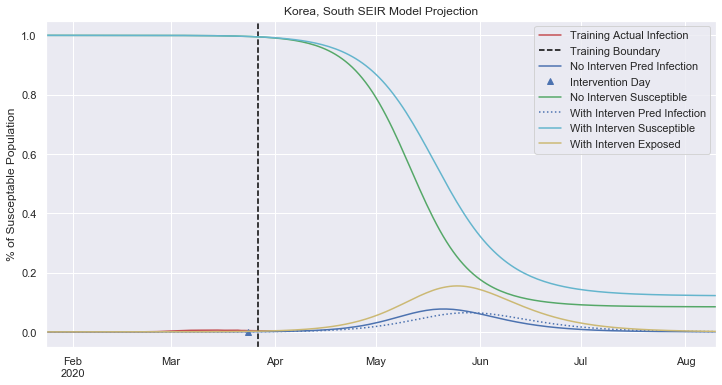

In [110]:
intervention_param = ['2020-03-24', 2.4] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-04-07'

display_output('Korea, South',intervention_param,obs_start,obs_end,full_SEIR_graph=True,retrain=False,i=20000) #900

# Reference 
<br> https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model
<br> https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296
<br> https://neherlab.org/covid19/
<br> https://www.who.int/bulletin/online_first/20-255695.pdf
<br> https://www.researchgate.net/publication/339323999_Epidemic_analysis_of_COVID-19_in_China_by_dynamical_modeling
